In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from anndata import AnnData
from scipy.io import mmread
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import seaborn as sb

In [188]:
#data_loc="I:\\mutiomics\\ICC\\BMK240704-CD182-ZX01-0101\\BMK_DATA_20240828172206_1\\Matrix\\backup\\Unknown_CD182-0050001_BSTViewer_project\\level_matrix\\level_6\\"
data_loc="I:\\mutiomics\\ICC\\BMK240704-CD182-ZX01-0101\\BMK_DATA_20240828172206_1\\Matrix\\backup\\Unknown_CD182-0050001_BSTViewer_project\\subdata\\L6_heAuto\\"
expression_matrix = mmread(f"{data_loc}matrix.mtx.gz").tocsc()
spatial_coords = pd.read_csv(f"{data_loc}barcodes_pos.tsv.gz", sep='\t', header=None)

In [189]:
spatial_coords=spatial_coords.iloc[:,[1,2]]

In [190]:
min_values = np.min(spatial_coords, axis=0)
max_values = np.max(spatial_coords, axis=0)

# 执行 Min-Max Scaling 到 [0, 1000] 范围
scaled_spatial_coords = 1000 * (spatial_coords - min_values) / (max_values - min_values)

In [191]:
spatial_coords

,1,2
0,542.960663,278.365308
1,538.819876,281.054828
2,534.679089,283.744348
3,530.538302,286.433868
4,526.397516,289.123388
...,...,...
12067,873.706004,705.998970
12068,869.565217,708.688490
12069,878.105590,708.240237
12070,873.964803,710.929757


In [204]:
adata = AnnData(X=expression_matrix.T, obsm={'spatial': spatial_coords.values})

In [205]:
print(expression_matrix.shape,spatial_coords.shape,cell_metadata.shape)
gene_metadata = pd.read_csv(f"{data_loc}features.tsv.gz", sep='\t', header=None)
adata.var_names = gene_metadata[1].values

(54752, 12072) (12072, 2) (2970016, 2)


In [215]:
image = Image.open(f"{data_loc}he_roi_small.png")
#image=image.resize((1024, 1024))
image_array = np.array(image)
library_id =  'sample_1'

# 将图像和相关信息添加到 AnnData 对象的 uns 中
adata.uns['spatial'] = {
    'sample_1': {  # 替换为实际 library_id
        'images': {
            'hires': image_array,  # 正确设置的图像数据
        },
        'scalefactors': {
            'tissue_hires_scalef': 1.02,
        }
    }
}
adata.uns['spatial'][library_id]['scalefactors']['spot_diameter_fullres'] = 5

In [207]:
image_array.shape

(1026, 1024, 3)

In [208]:
adata.obsm['spatial']

array([[542.96066253, 278.36530836],
       [538.81987578, 281.05482825],
       [534.67908903, 283.74434813],
       ...,
       [878.10559006, 708.24023705],
       [873.96480331, 710.92975694],
       [878.36438923, 713.17102351]])

normalizing counts per cell
    finished (0:00:00)


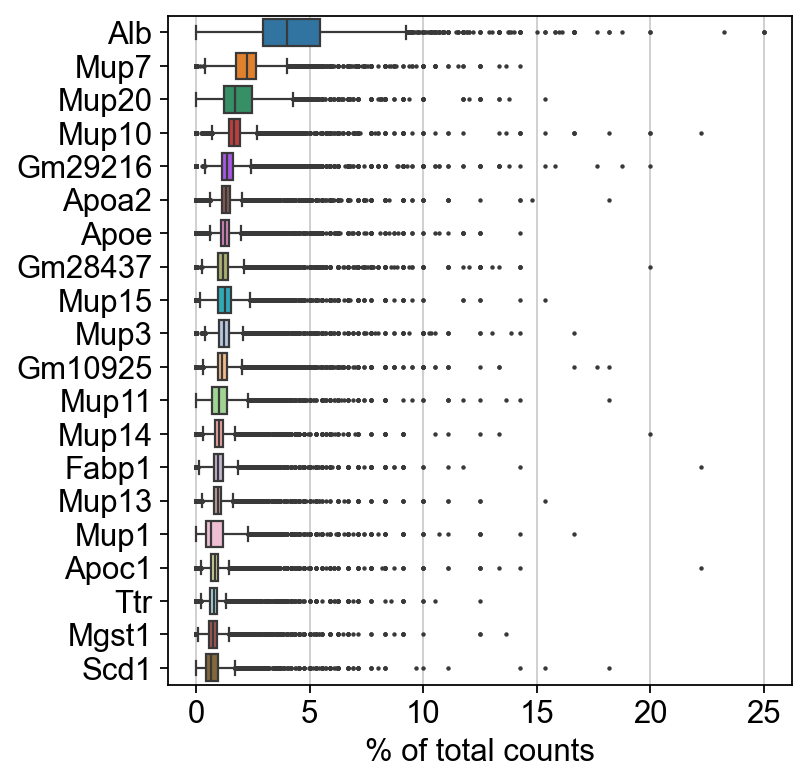

filtered out 2723 cells that have less than 1500 counts
Number of cells after min count filter: 9349
Number of cells after max count filter: 9349
Number of cells after MT filter: 9349


I:\mutiomics\pythonProject\.venv\lib\site-packages\scanpy\preprocessing\_simple.py:160: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


Number of cells after gene filter: 9349
filtered out 37627 genes that are detected in less than 10 cells
Number of genes after cell filter: 17125


In [209]:
adata.var_names_make_unique()
adata
sc.pl.highest_expr_genes(adata, n_top=20)
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['mt_frac'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['total_counts'] = adata.X.sum(axis=1).A1
sc.pp.filter_cells(adata, min_counts =1500)
print(f'Number of cells after min count filter: {adata.n_obs}')
sc.pp.filter_cells(adata, max_counts = 200000)
print(f'Number of cells after max count filter: {adata.n_obs}')
adata = adata[adata.obs['mt_frac'] < 1]
print(f'Number of cells after MT filter: {adata.n_obs}')
sc.pp.filter_cells(adata, min_genes = 0)
print(f'Number of cells after gene filter: {adata.n_obs}')
sc.pp.filter_genes(adata, min_cells=10)
print(f'Number of genes after cell filter: {adata.n_vars}')

In [210]:
sc.pp.normalize_total(adata, inplace = True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=2000, inplace=True)
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata,n_neighbors=10)

sc.tl.umap(adata)
sc.tl.leiden(adata, key_added='clusters')

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA


I:\mutiomics\pythonProject\.venv\lib\site-packages\scanpy\preprocessing\_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)
running Leiden clustering
    finished: found 9 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:00)


-----
anndata     0.10.7
scanpy      1.10.1
-----
PIL                         10.3.0
anyio                       NA
arrow                       1.3.0
asttokens                   NA
attr                        23.2.0
attrs                       23.2.0
babel                       2.14.0
certifi                     2024.02.02
cffi                        1.16.0
charset_normalizer          3.3.2
colorama                    0.4.6
comm                        0.2.2
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.9.0.post0
debugpy                     1.8.1
decorator                   5.1.1
defusedxml                  0.7.1
exceptiongroup              1.2.1
executing                   2.0.1
fastjsonschema              NA
fqdn                        NA
h5py                        3.11.0
idna                        3.7
igraph                      0.11.4
ipykernel                   6.29.4
ipywidgets                  8.1.2
isoduration                 N

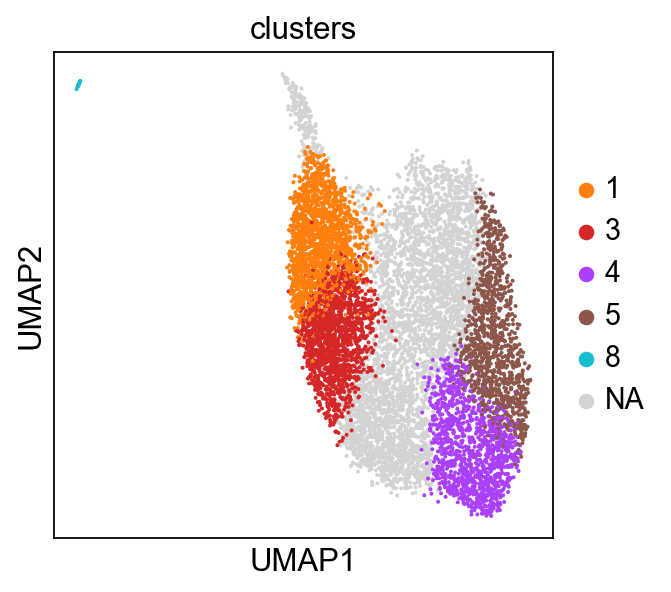

In [211]:
plt.rcParams['figure.figsize']=(8,8)
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)
sc.pl.umap(adata, color='clusters', palette=sc.pl.palettes.default_20,groups=["1","3","4","5","8","9","10"])

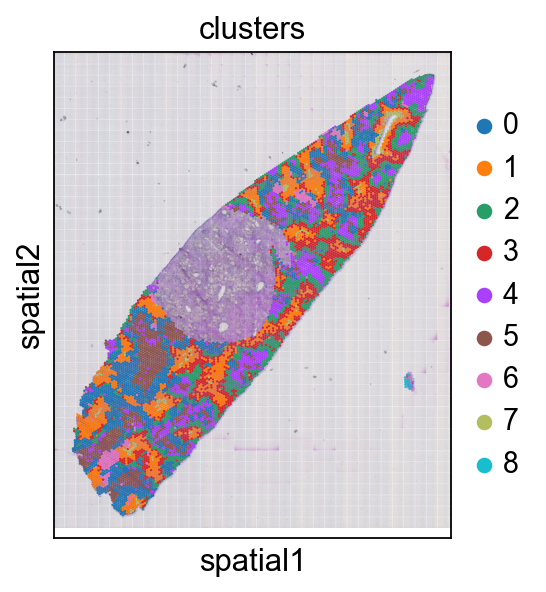

In [216]:
sc.pl.spatial(adata, img_key = "hires", color="clusters",size=1)

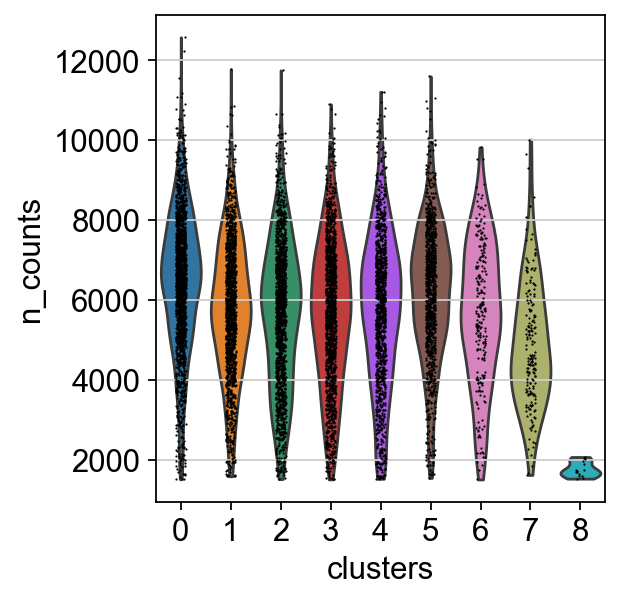

In [217]:
sc.pl.violin(adata, keys='n_counts', groupby='clusters')

In [218]:
adata.write(f"{data_loc}anndata.h5ad")